In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})





output_path = './plots_unb_bound_state_actr/'
prod_name = '300K'
path = '../Unbiased_MD/Bound_state_unbiased_state/CVS_DATA/'

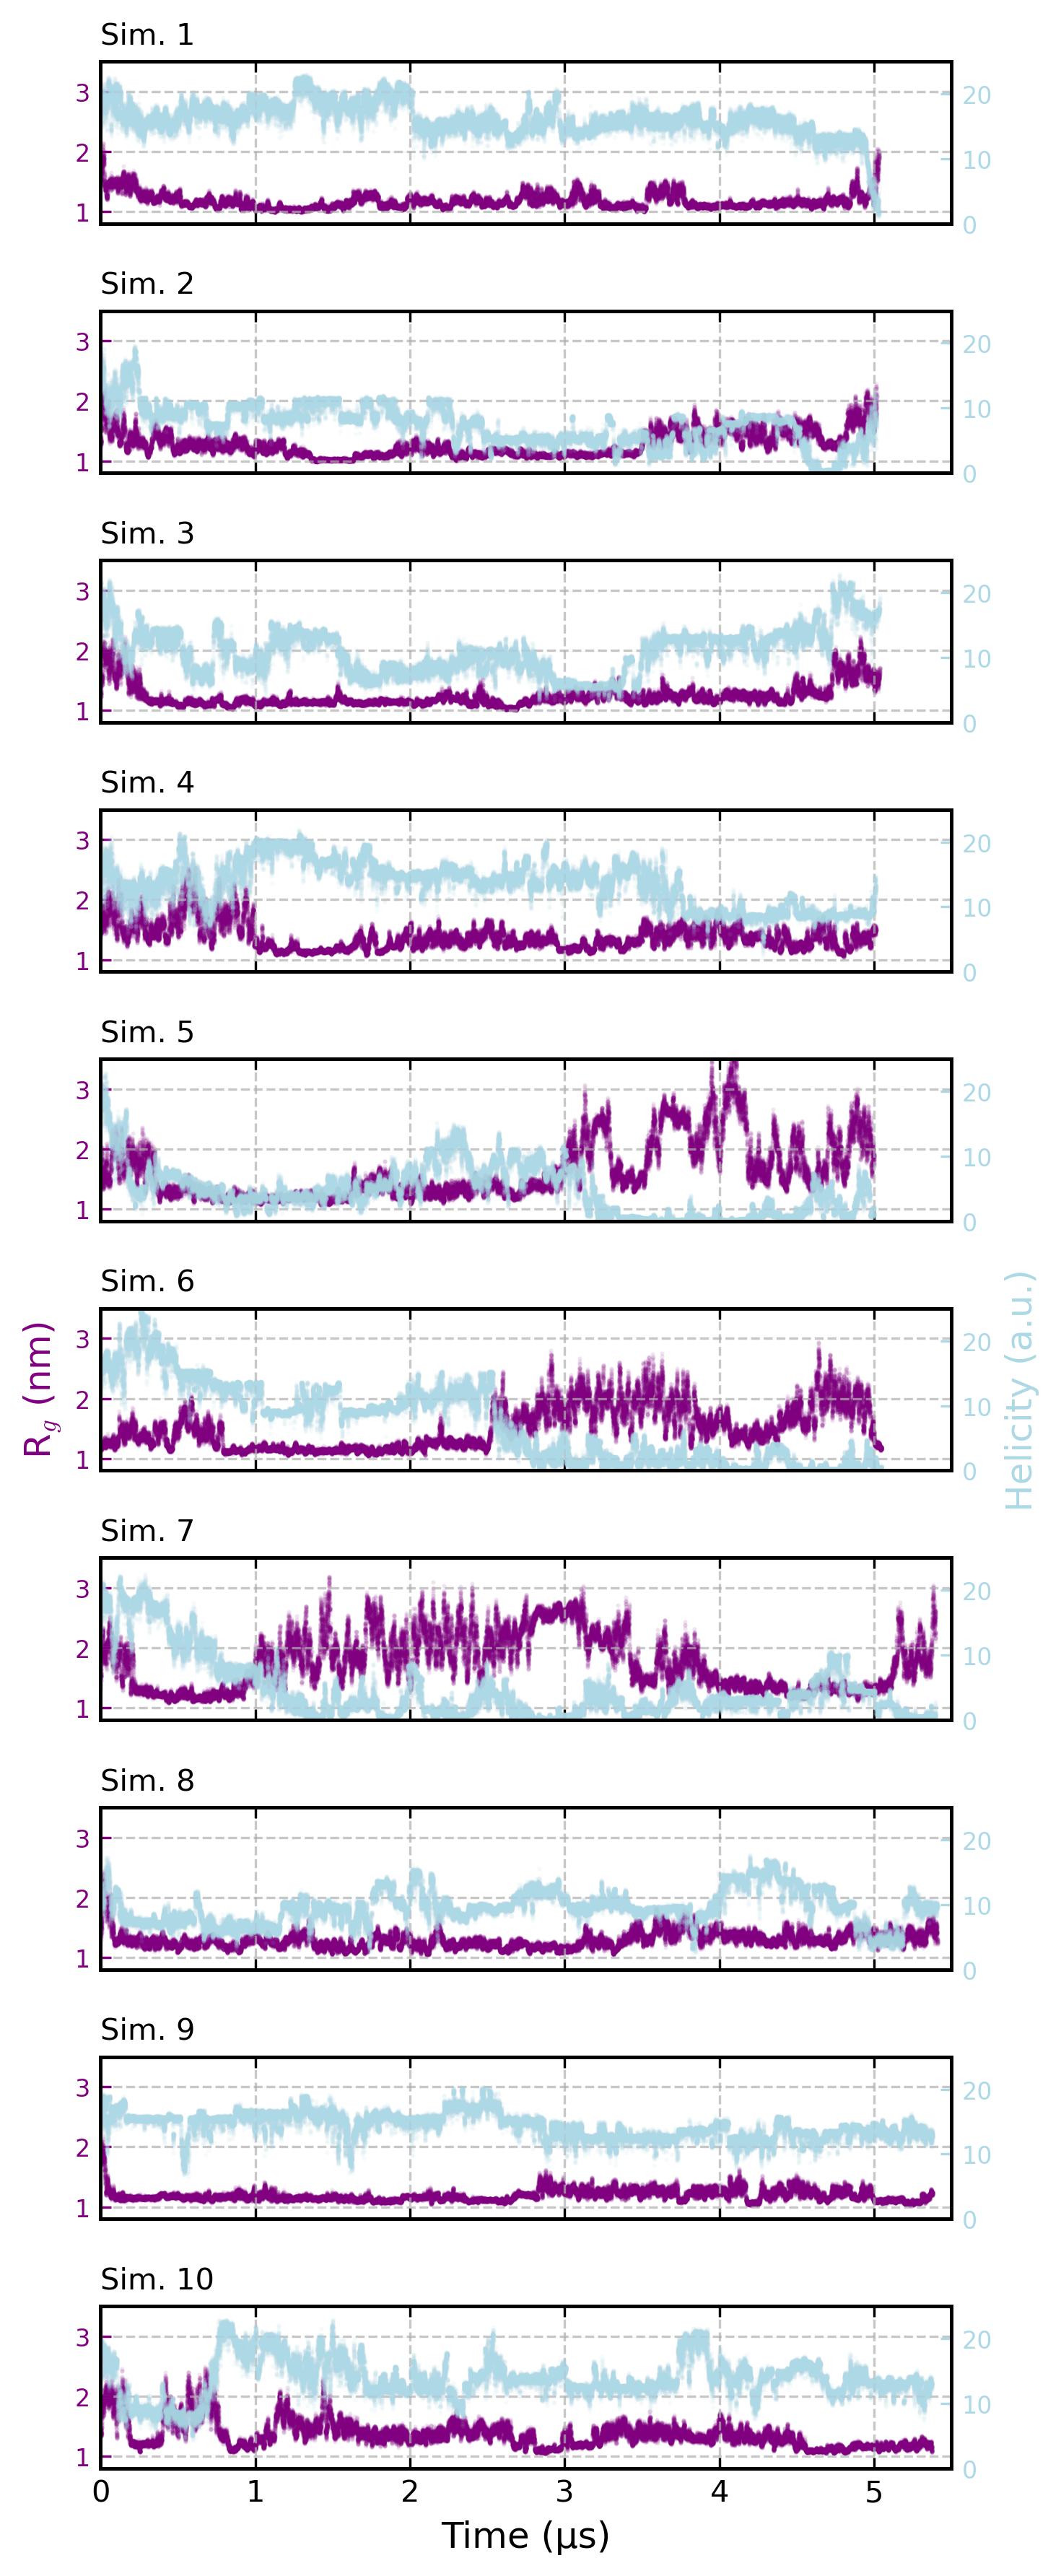

In [13]:


nsims = 10

fig, axes = plt.subplots(
    nrows=nsims,
    ncols=1,
    figsize=(5, 12),
    sharex=True
)

for sim in range(nsims):
    # Load and subsample data
    CVS = np.loadtxt(path + f'CVS_DATA.{sim}')
    time_data = np.arange(CVS.shape[0])/1e4
    ax_rg = axes[sim]
    ax_alpha = ax_rg.twinx()

    # Rg (left axis)
    ax_rg.scatter(
        time_data,
        CVS[:, 1],
        s=0.25,
        alpha=0.1,
        color="purple",
        rasterized=True
    )
    ax_rg.set_title(f'Sim. {sim+1}', fontsize = 10, loc="left")

    # alphaRMSD (right axis)
    ax_alpha.scatter(
        time_data,
        CVS[:, 2],
        s=0.25,
        alpha=0.1,
        color="lightblue",
        rasterized=True
    )

    ax_rg.set_ylim(0.8, 3.5)

    # Y labels only on outer axes
    if sim == nsims // 2:
        ax_rg.set_ylabel("R$_g$ (nm)", color="purple")
        ax_alpha.set_ylabel("Helicity (a.u.)", color="lightblue")

    # Clean up ticks
    ax_rg.tick_params(axis="y", colors="purple", labelsize=8)
    ax_alpha.tick_params(axis="y", colors="lightblue", labelsize=8)
    ax_alpha.set_ylim(0., 25)
    ax_alpha.grid(False)

# X-axis (only bottom panel)
axes[-1].set_xlabel("Time (μs)")
axes[-1].set_xticks([0, 1, 2, 3, 4, 5])
axes[-1].set_xlim(0, 5.5)

plt.tight_layout()
plt.savefig(output_path + f"{prod_name}_rg_alpha_per_sim.pdf", dpi=300)



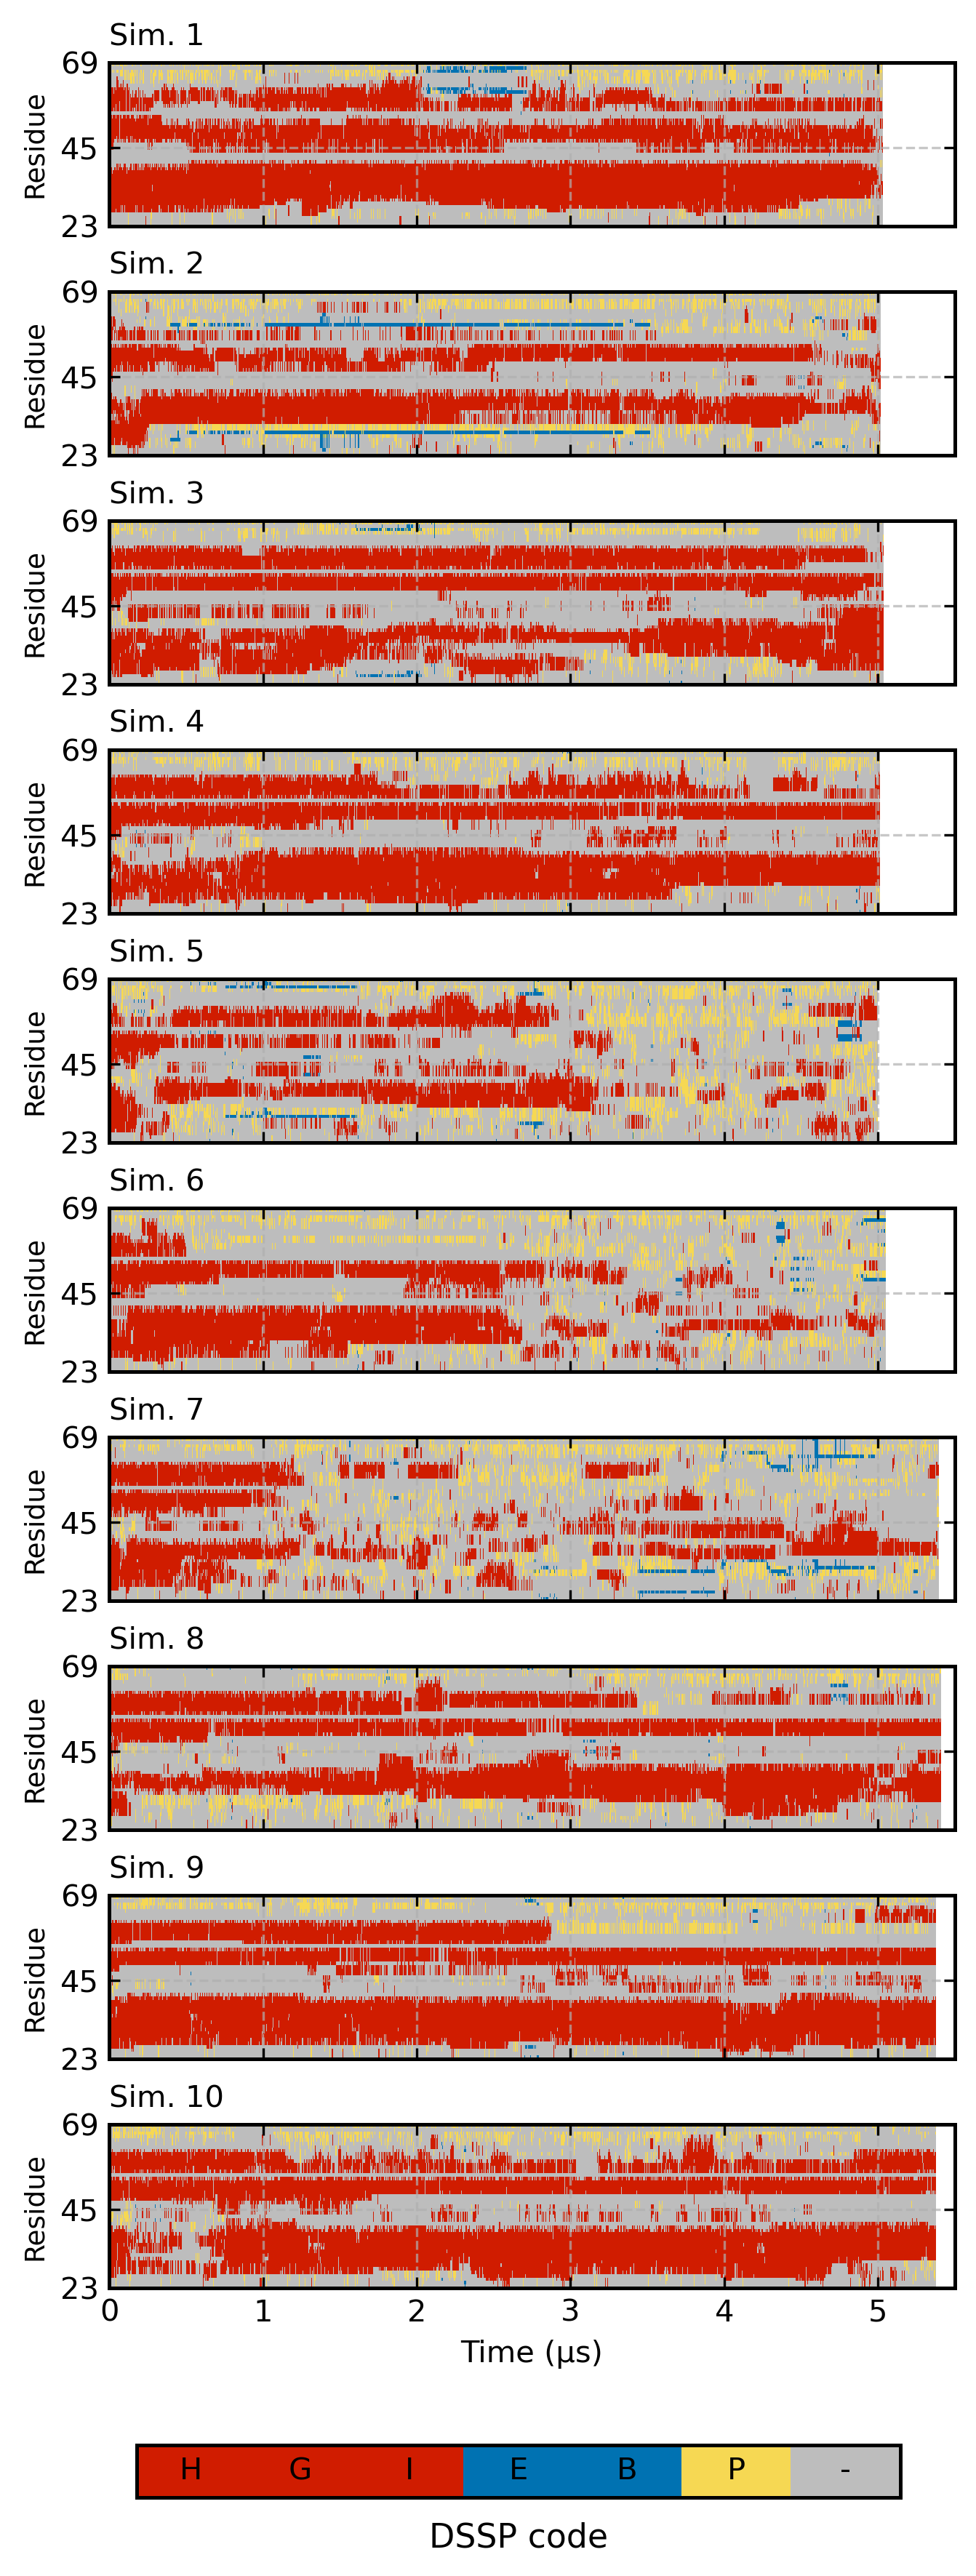

In [11]:
# dssp

from matplotlib import gridspec
from matplotlib.colors import ListedColormap
nsims = 10
residue_offset = 22

# --- Figure setup: nreplica rows only, colorbar will be separate ---
fig_height = 0.8 * nsims + 4
fig = plt.figure(figsize=(5, fig_height))
gs = gridspec.GridSpec(nsims, 1, hspace=0.4)


# --- DSSP codes & colors ---
dssp_codes = ["H", "G", "I", "E", "B", "P","-"]
colors = [
    "#D01C00",  # H
    "#D01C00",  # G
    "#D01C00",  # I
    "#0072B2",  # E
    "#0072B2",  # B
    "#F6D853",  # P
    "#BDBDBD"   # -
]


# --- DSSP mapping ---
dssp_mapping = {
    'H': 0,  # α-helix
    'G': 1,  # 3_10 helix
    'I': 2,  # π-helix
    'E': 3,  # β-strand
    'B': 4,  # β-bridge
    'P': 5,  # PPII
    '-': 6,  # bend, turn 
    '-': 7  # coil
}

cmap = ListedColormap(colors)




# --- Plot each replica ---
axes = []
for i in range(nsims):
    ax = fig.add_subplot(gs[i, 0])
    axes.append(ax)
    with open(path + f'../dssp_analysis/dssp{i}.dat') as f:
        dssp_lines = [line.strip()[1:-1] for line in f] # discard Ace and NME (terminal residues)
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    dssp_array = np.array([[dssp_mapping.get(c, 7) for c in line] for line in dssp_lines])[::2].T
    time_per_frame_ps = 100
    total_time_us = n_frames * time_per_frame_ps / 1e6
    im = ax.imshow(dssp_array, aspect='auto', origin='lower', cmap=cmap,
                   extent=[0, total_time_us, 1+residue_offset, n_residues+residue_offset], interpolation='nearest', rasterized=True)
    ax.set_title(f"Sim. {i+1}", fontsize=10, loc="left")
    ax.set_ylabel("Residue", fontsize=9)
    ax.set_yticks([1+residue_offset, n_residues//2 +residue_offset, n_residues+residue_offset])
    ax.set_ylim(1+residue_offset, n_residues+residue_offset)
    ax.set_xlim(0,5.5)
    if i < nsims - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (µs)", fontsize=10)

# --- Add colorbar *below* all axes ---
cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.02])  # [left, bottom, width, height]
cb = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.ax.tick_params(length=0)
cb.set_ticks([])

# Label each DSSP code directly in color patches
for idx, label in enumerate(dssp_codes):
    cb.ax.text((idx + 0.5) / len(colors), 0.5, label,
               ha='center', va='center', fontsize=10, color='black',
               transform=cb.ax.transAxes)

cb.set_label("DSSP code", fontsize=11, labelpad=8)

plt.subplots_adjust(bottom=0.12, top=0.97, hspace=0.4)
plt.savefig(output_path+f"{prod_name}_replicas_dssp_heatmap_colorbar_bottom.pdf",
            bbox_inches="tight")


Done


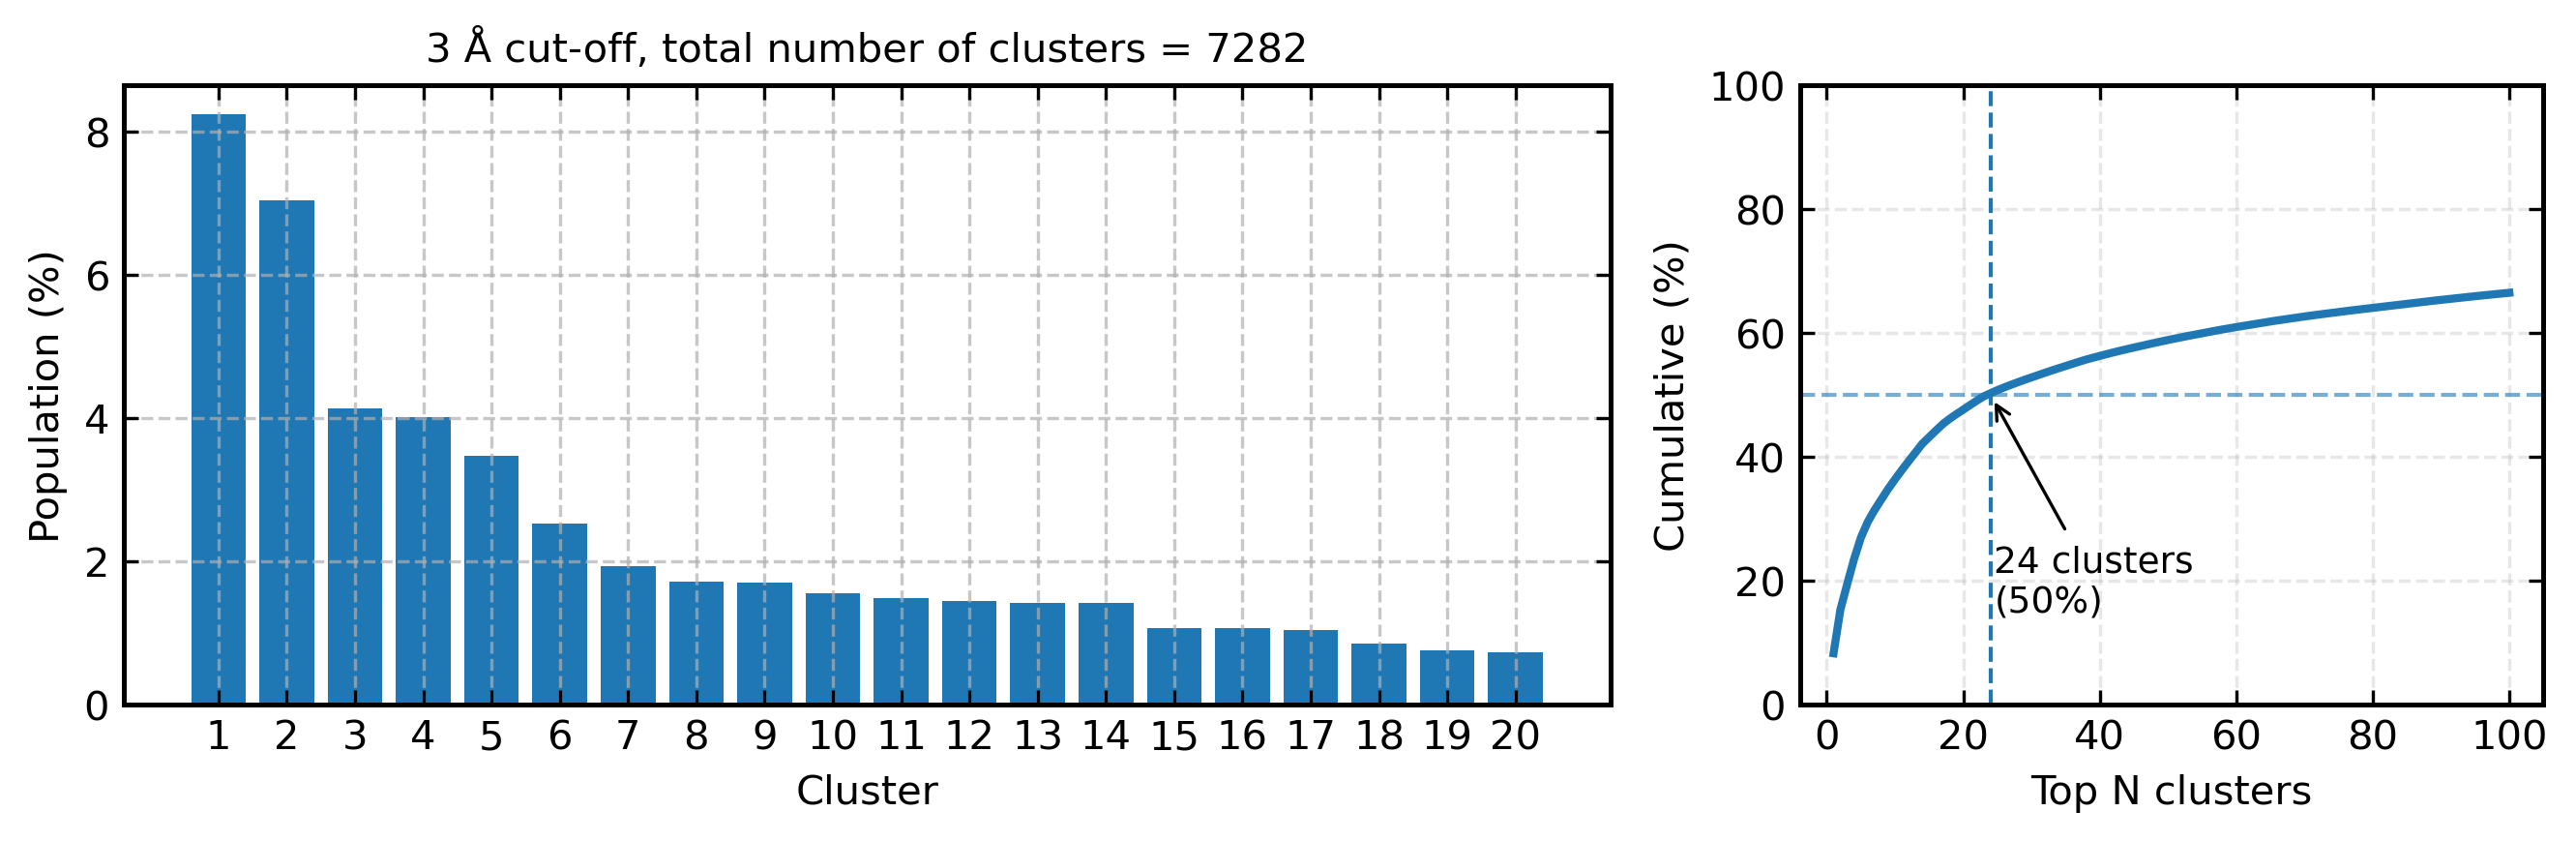

In [73]:
# clustering populations
cutoff = 3
nframes = 51712 # downsampled to 1 ns frequency

# ------------------------------------------------
# USER INPUT
# ------------------------------------------------
clusters_file = path+f"../clustering/clustering_{cutoff}A/clusters.ndx"     

# ------------------------------------------------
# PARSE CLUSTERS.NDX
# ------------------------------------------------
clusters = {}
current_cluster = None

with open(clusters_file, "r") as f:
    for line in f:
        line = line.strip()

        if line.startswith("[") and line.endswith("]"):
            current_cluster = line.strip("[]")
            clusters[current_cluster] = []
        elif current_cluster and line:
            nums = [int(x)-1 for x in line.split()]
            clusters[current_cluster].extend(nums)

# ------------------------------------------------
# COMPUTE POPULATIONS
# ------------------------------------------------
rows = []
for cname, frames in clusters.items():
    unweighted_pop = (len(frames)/nframes)*100
    rows.append([cname, np.round(unweighted_pop, 2)])

df = pd.DataFrame(rows, columns=["Cluster", "Population (%)"])

# ------------------------------------------------
# SORT BY WEIGHTED POPULATION
# ------------------------------------------------
df_sorted = df.sort_values("Population (%)", ascending=False)

# ------------------------------------------------
# PLOT TOP 20 + CUMULATIVE POPULATION
# ------------------------------------------------
top20 = df_sorted.head(20).copy()
top100 = df_sorted.head(100).copy()
top100["Cumulative Population (%)"] = top100["Population (%)"].cumsum()

fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 3),
    gridspec_kw={"width_ratios": [2, 1]}
)

# ---- Left panel: populations ----
axes[0].bar(np.arange(20) + 1, top20["Population (%)"])
axes[0].set_xticks(np.arange(20) + 1)
axes[0].set_xlabel("Cluster", fontsize=10)
axes[0].set_ylabel("Population (%)", fontsize=10)
axes[0].set_title(f"{cutoff} Å cut-off, total number of clusters = {len(clusters.keys())}", fontsize=10)

# ---- Right panel: cumulative population ----
n = len(top100)
x = np.arange(1, n + 1)
y = top100["Cumulative Population (%)"].to_numpy()

axes[1].plot(x, y)
axes[1].set_xlabel("Top N clusters", fontsize=10)
axes[1].set_ylabel("Cumulative (%)", fontsize=10)
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=0.3)

# ------------------------------------------------
# FIND N CLUSTERS FOR 50% POPULATION
# ------------------------------------------------
threshold = 50.0
cum_pop = top100["Cumulative Population (%)"].to_numpy()

idx_50 = np.argmax(cum_pop >= threshold)
if cum_pop[idx_50] < threshold:
    n50 = None
else:
    n50 = idx_50 + 1

# ---- 50% threshold line ----
axes[1].axhline(50, linestyle="--", linewidth=1, alpha=0.6)

if n50 is not None:
    axes[1].axvline(n50, linestyle="--", linewidth=1)
    axes[1].annotate(
        f"{n50} clusters\n(50%)",
        xy=(n50, 50),
        xytext=(n50 + 0.5, 15),
        arrowprops=dict(arrowstyle="->", linewidth=0.8),
        fontsize=9,
        ha="left"
    )

plt.tight_layout()
plt.savefig(output_path + f"top20_clusters_{cutoff}A.pdf", dpi=300)


# ------------------------------------------------
# SAVE POPULATIONS
# ------------------------------------------------
df_sorted.to_csv(output_path+f"top20_clusters_{cutoff}A.csv", index=False)

print('Done')


Done


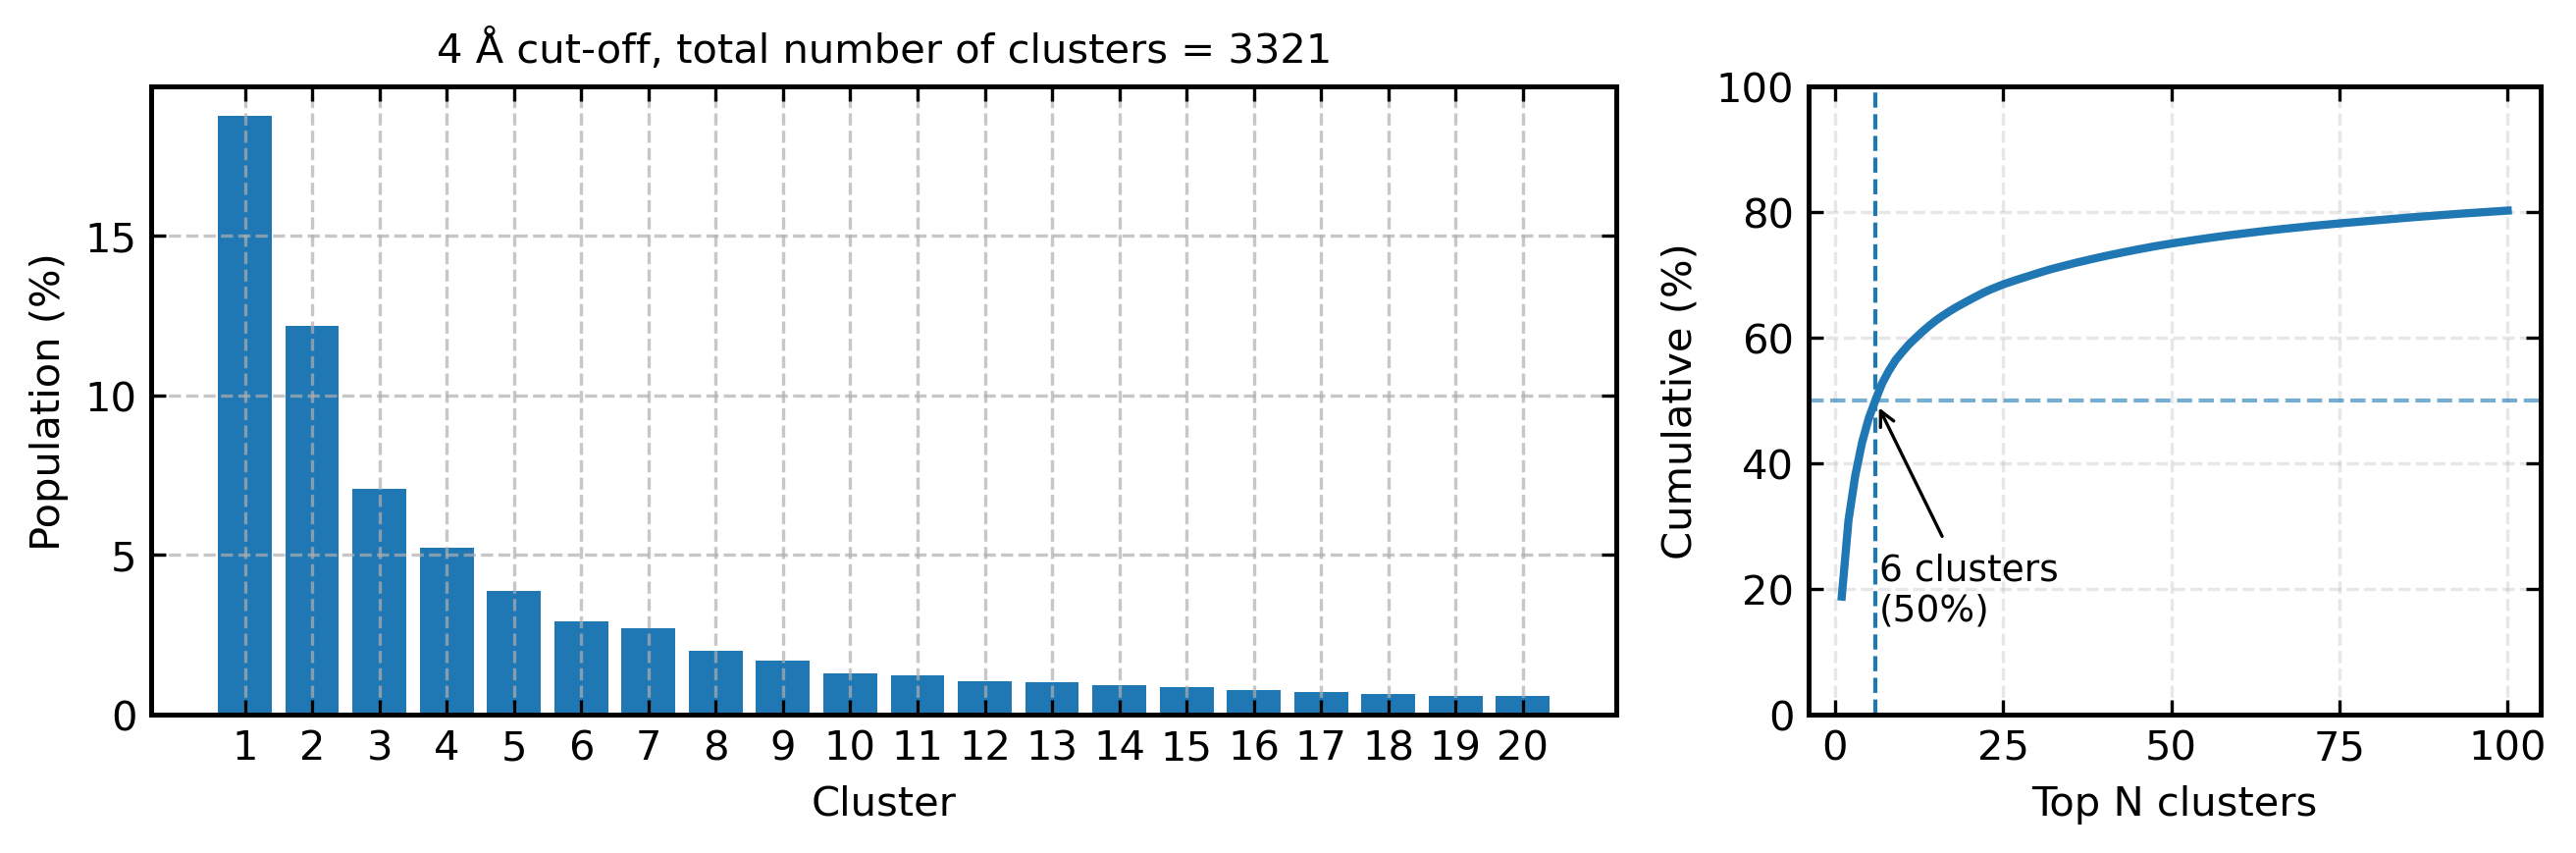

In [74]:
# clustering populations
cutoff = 4
nframes = 51712 # downsampled to 1 ns frequency

# ------------------------------------------------
# USER INPUT
# ------------------------------------------------
clusters_file = path+f"../clustering/clustering_{cutoff}A/clusters.ndx"     

# ------------------------------------------------
# PARSE CLUSTERS.NDX
# ------------------------------------------------
clusters = {}
current_cluster = None

with open(clusters_file, "r") as f:
    for line in f:
        line = line.strip()

        if line.startswith("[") and line.endswith("]"):
            current_cluster = line.strip("[]")
            clusters[current_cluster] = []
        elif current_cluster and line:
            nums = [int(x)-1 for x in line.split()]
            clusters[current_cluster].extend(nums)

# ------------------------------------------------
# COMPUTE POPULATIONS
# ------------------------------------------------
rows = []
for cname, frames in clusters.items():
    unweighted_pop = (len(frames)/nframes)*100
    rows.append([cname, np.round(unweighted_pop, 2)])

df = pd.DataFrame(rows, columns=["Cluster", "Population (%)"])

# ------------------------------------------------
# SORT BY WEIGHTED POPULATION
# ------------------------------------------------
df_sorted = df.sort_values("Population (%)", ascending=False)

# ------------------------------------------------
# PLOT TOP 20 + CUMULATIVE POPULATION
# ------------------------------------------------
top20 = df_sorted.head(20).copy()
top100 = df_sorted.head(100).copy()
top100["Cumulative Population (%)"] = top100["Population (%)"].cumsum()

fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 3),
    gridspec_kw={"width_ratios": [2, 1]}
)

# ---- Left panel: populations ----
axes[0].bar(np.arange(20) + 1, top20["Population (%)"])
axes[0].set_xticks(np.arange(20) + 1)
axes[0].set_xlabel("Cluster", fontsize=10)
axes[0].set_ylabel("Population (%)", fontsize=10)
axes[0].set_title(f"{cutoff} Å cut-off, total number of clusters = {len(clusters.keys())}", fontsize=10)

# ---- Right panel: cumulative population ----
n = len(top100)
x = np.arange(1, n + 1)
y = top100["Cumulative Population (%)"].to_numpy()

axes[1].plot(x, y)
axes[1].set_xlabel("Top N clusters", fontsize=10)
axes[1].set_ylabel("Cumulative (%)", fontsize=10)
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=0.3)

# ------------------------------------------------
# FIND N CLUSTERS FOR 50% POPULATION
# ------------------------------------------------
threshold = 50.0
cum_pop = top100["Cumulative Population (%)"].to_numpy()

idx_50 = np.argmax(cum_pop >= threshold)
if cum_pop[idx_50] < threshold:
    n50 = None
else:
    n50 = idx_50 + 1

# ---- 50% threshold line ----
axes[1].axhline(50, linestyle="--", linewidth=1, alpha=0.6)

if n50 is not None:
    axes[1].axvline(n50, linestyle="--", linewidth=1)
    axes[1].annotate(
        f"{n50} clusters\n(50%)",
        xy=(n50, 50),
        xytext=(n50 + 0.5, 15),
        arrowprops=dict(arrowstyle="->", linewidth=0.8),
        fontsize=9,
        ha="left"
    )

plt.tight_layout()
plt.savefig(output_path + f"top20_clusters_{cutoff}A.pdf", dpi=300)


# ------------------------------------------------
# SAVE POPULATIONS
# ------------------------------------------------
df_sorted.to_csv(output_path+f"top20_clusters_{cutoff}A.csv", index=False)

print('Done')


In [50]:
# write top N cluster centroids that capture 50%
import os
import MDAnalysis as mda
cutoff = 4
N = 6

# ------------------------------------------------
# USER INPUT
# ------------------------------------------------
clusters_pdb = path + f"../clustering/clustering_{cutoff}A/clusters.pdb"
output_dir = path + f"../clustering/clustering_{cutoff}A/top6_clusters/"

# ------------------------------------------------
# LOAD PDB TRAJECTORY
# ------------------------------------------------
u = mda.Universe(clusters_pdb)
frames = np.arange(N)

# ------------------------------------------------
# WRITE STRUCTURES
# ------------------------------------------------
for i, frame in enumerate(frames):
    u.trajectory[frame]
    outname = os.path.join(output_dir, f"centroid_{int(i+1)}.pdb")
    u.atoms.write(outname)

print("Done writing top 50% population structures.")


/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/thd711/.conda/envs/HDXproject/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


Done writing top 50% population structures.


In [66]:
# Lifetime analysis

# -----------------------------
# Parameters
# -----------------------------
frame_dt = 1  # ns per frame
max_gap_ns = 20 # ns
max_gap_frames = max_gap_ns // frame_dt  

# -----------------------------
# Compute lifetimes
# -----------------------------
lifetimes = []

for cname, frames in clusters.items():
    frames_sorted = sorted(frames)
    
    if not frames_sorted:
        continue
    
    start = frames_sorted[0]
    current_length = 1
    
    for i in range(1, len(frames_sorted)):
        gap = frames_sorted[i] - frames_sorted[i-1]
        if gap <= max_gap_frames:
            current_length += gap  # include gap frames
        else:
            # end of a continuous stretch
            lifetimes.append([cname, current_length * frame_dt])
            start = frames_sorted[i]
            current_length = 1
    
    # append last stretch
    lifetimes.append([cname, current_length * frame_dt])

# -----------------------------
# Convert to DataFrame
# -----------------------------
df_lifetimes = pd.DataFrame(lifetimes, columns=["Cluster", "Lifetime (ns)"])

# Optional: summary statistics per cluster
df_summary = df_lifetimes.groupby("Cluster")["Lifetime (ns)"].agg(
    ['count', 'mean', 'median', 'max']
).reset_index()

# Save results
df_lifetimes.to_csv(output_path + f"cluster_lifetimes_{cutoff}A.csv", index=False)
df_summary.to_csv(output_path + f"cluster_lifetimes_summary_{cutoff}A.csv", index=False)

print("Done computing lifetimes")


Done computing lifetimes


In [68]:
df_summary[:30]

,Cluster,count,mean,median,max
0,Cluster_0001,33,191.878788,50.0,1163
1,Cluster_0002,12,357.000000,12.0,2137
2,Cluster_0003,10,278.900000,111.5,1512
3,Cluster_0004,28,85.250000,9.5,1168
4,Cluster_0005,37,68.243243,7.0,514
5,Cluster_0006,19,97.842105,33.0,420
6,Cluster_0007,11,116.818182,4.0,582
7,Cluster_0008,22,65.772727,30.0,401
8,Cluster_0009,7,166.000000,17.0,575
9,Cluster_0010,47,38.297872,16.0,197
